### This file is for previewing and seeing what the neural network was capable of producing

Import all necessary elements

In [1]:
from termcolor import colored
# TODO: FIX THIS OLD IMPORTED CODE TO WORK WITH THE NEW CODE

print(colored('Loading libraries...', attrs=['bold']))
import os
import math
print(colored('Loading numpy...', attrs=['bold']))
import numpy as np
print(colored('Loading matplotlib...', attrs=['bold']))
import matplotlib.pyplot as plt
from IPython.display import Audio
from numpy.fft import fft, ifft
import time as systemClock
print(colored('Loading tqdm...', attrs=['bold']))
from tqdm import tqdm
print(colored('Loading datasync...', attrs=['bold']))
import sys
sys.path.append('./source/network')
from Dataloader import datasync as sync
from Dataloader import loader
print(colored('Loading keras...', attrs=['bold']))
import keras
print(colored('Loading tensorflow...', attrs=['bold']))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import keras.backend as K
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.client import device_lib
print(colored('All libraries loaded', attrs=['bold']))
from datetime import datetime

Loading libraries...
Loading numpy...
Loading matplotlib...
Loading tqdm...
Loading datasync...
Loading keras...
Loading tensorflow...
All libraries loaded


In [2]:
chunk_length_seconds = 0.125
sample_rate = 44000
sample_per_chunk = int(sample_rate * chunk_length_seconds)

Initialize all data path

In [6]:
absolute_path = os.path.join('/home/lemonorange/catRemixV2')
data_root_path = os.path.join(absolute_path, 'data')
input_path = os.path.join(data_root_path, 'wav')
label_data_path = os.path.join(data_root_path, 'rawMid')
storage_path = os.path.join(absolute_path, 'network')
cycle_path = 'cyc1'

network_path = os.path.join(storage_path, cycle_path, 'snp_200.h5')
train_loss_path = os.path.join(storage_path, cycle_path, 'train_loss.txt')
val_loss_path = os.path.join(storage_path, cycle_path, 'val_loss.txt')

train_loss_file = open(train_loss_path)
val_loss_file = open(val_loss_path)

In [7]:
# parse in losses
loss_names = [i.split('=')[0] for i in train_loss_file.readline().split(';')][:-1]
loss_colors = ['red', 'green', 'blue', 'magenta', 'yellow', 'black', 'cyan']

train_loss_file.seek(0)
train_loss = []
for entry in train_loss_file:
    train_loss.append(np.array(
        [i.split('=')[1] for i in entry.split(';')[:-1]]
    ))
train_loss = np.array(train_loss)

val_loss = []
for entry in val_loss_file:
    val_loss.append(np.array(
        [i.split('=')[1] for i in entry.split(';')[:-1]]
    ))
val_loss = np.array(val_loss)

**Plot the data out**

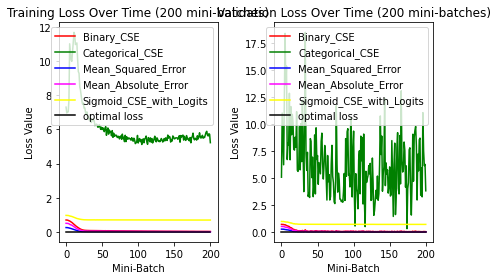

In [8]:
# plot them
x = np.arange(train_loss.shape[0])
zero = np.zeros(x.shape[0])

figure, axis = plt.subplots(1,2) # create subplot

for i in range(len(loss_names)): # plot the actual data
    axis[0].plot(x, train_loss[:,i].astype(np.float32), color=loss_colors[i], label=loss_names[i])

axis[0].plot(x, zero, color='black', label='optimal loss')
axis[0].legend()
axis[0].set_title('Training Loss Over Time (200 mini-batches)')
axis[0].set_xlabel('Mini-Batch')
axis[0].set_ylabel('Loss Value')

for i in range(len(loss_names)): # plot the actual data
    axis[1].plot(x, val_loss[:,i].astype(np.float32), color=loss_colors[i], label=loss_names[i])
axis[1].plot(x, zero, color='black', label='optimal loss')
axis[1].legend()
axis[1].set_title('Validation Loss Over Time (200 mini-batches)')
axis[1].set_xlabel('Mini-Batch')
axis[1].set_ylabel('Loss Value')

plt.tight_layout()
plt.show()

In [9]:
model = keras.models.load_model(network_path)
all_files = os.listdir(input_path)

file = all_files[0] # extract a testing file

unpaired_input = loader.parse_input(file, input_path) # parse input
unpaired_label = sync.trim_front(loader.parse_label(file, label_data_path)) # trimming the MIDI and syncing the data
input, label = sync.sync_data(unpaired_input, unpaired_label, len(unpaired_label)) # pair IO + trim
label = np.array(loader.encode_multihot(label)) # encode label

input = np.array(input)
input = np.reshape(input, (input.shape[0], 1, input.shape[1])) # reshape to a tensor which the neural net can use

In [10]:
output = model.predict(input)

note_to_freq = lambda note : np.float32(440 * 2 ** ((note-69)/12))
note_to_freq_with_offset = lambda note : np.float32(440 * 2 ** (((note+21)-69)/12))

# parse the multi-hot encoding into raw numbers
threshold = 0.505

note_out = []
for point in output: # read in all data points
    point_note_out = [] # for every one hot encoding, save the significant notes
    for i in range(point.shape[0]):
        if(point[i] > threshold):
            point_note_out.append(i)
    if(len(point_note_out) == 0): point_note_out.append(0)
    note_out.append(np.array(point_note_out))

# get a multi-hot encoding of that
encoded_note_out = loader.encode_multihot(note_out)

sample_rate = 44000
length = np.float32(sample_per_chunk/sample_rate)

t = np.linspace(0, length, int(sample_rate * length))  #  Produces a sample lengthed note

final = []
# loop through all note vectors and synthesize them into sine waves
for i in range(len(note_out)):
    # silence is represented by an all zero vector!
    if(np.all(encoded_note_out[0] == np.zeros(88))): # the case that it is silent
        final.append(np.sin(0*t)) # append a silence to the final sequence
        continue

    # if it is not a silence, create the fourier transform
    overall = np.sin(note_to_freq_with_offset(note_out[i][0]) * 2 * np.pi * t) # take full cycle of 2pi radians and scale them by scaler T
    for freq in note_out[i][1:]:
        overall += np.sin(note_to_freq_with_offset(freq) * 2 * np.pi * t)
    final.append(overall)

gen = np.concatenate(final)

flattend_input = input.reshape((1,-1))[0]

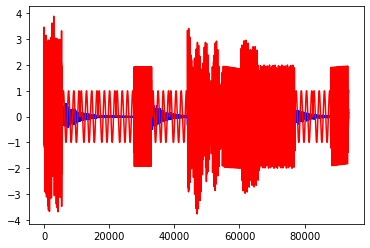

In [12]:
plt.plot(flattend_input, color='blue')
plt.plot(gen, color='red')

In [13]:
Audio(flattend_input, rate=sample_rate)
Audio(gen, rate=sample_rate)